In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/synthetic-data-ham10000/ISIC2018_Task3_Test_GroundTruth.csv
/kaggle/input/synthetic-data-ham10000/synthetic_dataset_labels.csv
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/AKIEC_3095_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/MEL_3269_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/NV_6606_R.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/DF_2189_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/MEL_3233_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/AKIEC_0314_R.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/BCC_3318_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/MEL_1917_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/Synthetic_Dataset/MEL_1320_F.jpg
/kaggle/input/synthetic-data-ham10000/Synthetic_Dataset/

In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2025-08-08 04:43:42.743636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754628222.970114      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754628223.039065      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis and Preprocessing

In [3]:
# Define paths
base_dir = "/kaggle/input/synthetic-data-ham10000"
train_img_dir = os.path.join(base_dir, "Synthetic_Dataset/Synthetic_Dataset")
test_img_dir = os.path.join(base_dir, "test_images/test_images")

train_csv_path = os.path.join(base_dir, "synthetic_dataset_labels.csv")
test_csv_path = os.path.join(base_dir, "ISIC2018_Task3_Test_GroundTruth.csv")

In [4]:
# Load labels
df = pd.read_csv(train_csv_path)
df.head()

,filename,NV,MEL,BKL,BCC,AKIEC,VASC,DF
0,NV_0001_R.jpg,1,0,0,0,0,0,0
1,NV_0002_R.jpg,1,0,0,0,0,0,0
2,NV_0003_R.jpg,1,0,0,0,0,0,0
3,NV_0004_R.jpg,1,0,0,0,0,0,0
4,NV_0005_R.jpg,1,0,0,0,0,0,0


In [5]:
# Confirm class names
# Extract class names (all columns except the first one)
class_names = df.columns[1:].tolist()
print("Detected classes:", class_names)

Detected classes: ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']


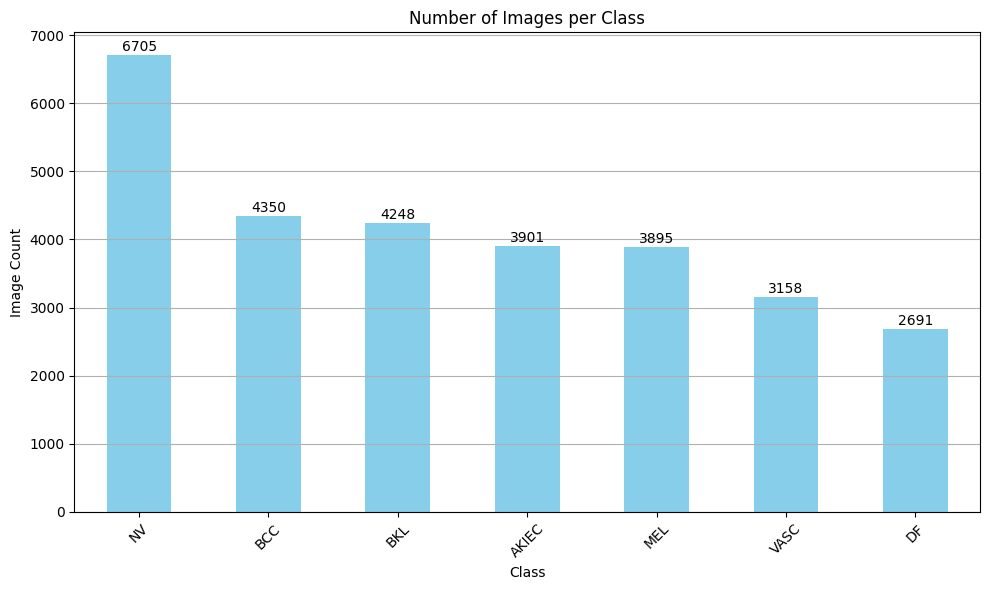

In [6]:
# Plot class distribution from one-hot encoded columns
class_counts = df[class_names].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = class_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Add text labels above bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 10, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.show()

In [7]:
# Create label indices for stratification
df['label_idx'] = df[class_names].values.argmax(axis=1)

# Stratified split
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label_idx'],
    random_state=42
)

# Drop label_idx column from both (optional)
train_df.drop(columns=['label_idx'], inplace=True)
val_df.drop(columns=['label_idx'], inplace=True)

In [8]:
# Only allow valid image extensions
valid_exts = ('.jpg', '.jpeg', '.png')
train_df = train_df[train_df['filename'].str.lower().str.endswith(valid_exts)]
val_df = val_df[val_df['filename'].str.lower().str.endswith(valid_exts)]

In [9]:
from PIL import Image
import os

corrupt_files = []

for fname in os.listdir(train_img_dir):
    if not fname.lower().endswith('.jpg'):
        continue
    try:
        img = Image.open(os.path.join(train_img_dir, fname))
        img.verify()
    except Exception:
        corrupt_files.append(fname)

print(f"Corrupt images: {len(corrupt_files)}")
print(corrupt_files[:5])

Corrupt images: 1
['DF_0099_R.jpg']


In [10]:
# Remove from both train and val sets if it exists
train_df = train_df[~train_df['filename'].isin(corrupt_files)]
val_df = val_df[~val_df['filename'].isin(corrupt_files)]

In [11]:
# Image processing and augmentation
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

# Training augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2)
)

# Validation preprocessing only
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [12]:
# Flow from dataframe
# Training generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img_dir,
    x_col='filename',
    y_col=class_names,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

# Validation generator
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_img_dir,
    x_col='filename',
    y_col=class_names,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 23157 validated image filenames.
Found 5790 validated image filenames.


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 7)
Pixel range: -1.0 to 1.0


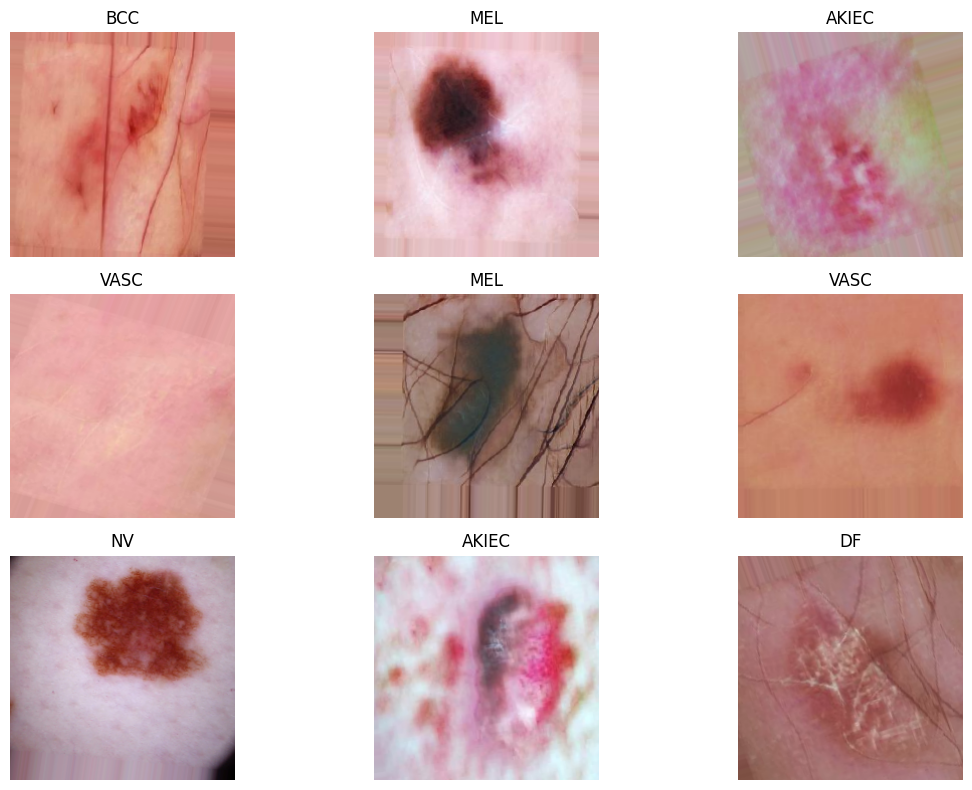

In [13]:
# Sanity check
# Grab a batch from the training generator
images, labels = next(train_gen)

# Check shapes
print("Image batch shape:", images.shape)      # (BATCH_SIZE, 224, 224, 3)
print("Label batch shape:", labels.shape)      # (BATCH_SIZE, 7)
print("Pixel range:", images.min(), "to", images.max())  # Should be in [-1, 1]

# Show a few images with their label indices
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = (images[i] + 1) / 2  # Convert back to [0, 1] for display
    plt.imshow(img)
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot to class index
train_labels_idx = train_df[class_names].values.argmax(axis=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=train_labels_idx
)

# Map to dict {0: weight, 1: weight, ...}
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.6167305848513902, 1: 1.0616633046029709, 2: 0.9735558732027243, 3: 0.950615763546798, 4: 1.0599624662425047, 5: 1.3096369189005768, 6: 1.5372411046202867}


# Building the Model and Training

In [15]:
# Import libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [16]:
# Define the model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True  # Fine-tune entire model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

I0000 00:00:1754628387.367054      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 2,388,743 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [17]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [18]:
# Setup callbacks
callbacks = [
    ModelCheckpoint("best_model_synthetic_augmented.keras", 
                    monitor="val_accuracy", 
                    save_best_only=True, 
                    verbose=1),
    
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.5, 
                      patience=3, 
                      min_lr=1e-6,
                      verbose=1),
    
    EarlyStopping(monitor='val_accuracy', 
                  patience=7, 
                  restore_best_weights=True,
                  verbose=1)
]

In [19]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1754628428.910021      61 service.cc:148] XLA service 0x7f4da0003ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754628428.911006      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754628432.199023      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1754628438.454829      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754628438.651986      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/724 ━━━━━━━━━━━━━━━━━━━━ 11:31:19 57s/step - accuracy: 0.1562 - loss: 2.5868

I0000 00:00:1754628449.606005      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


325/724 ━━━━━━━━━━━━━━━━━━━━ 3:00 451ms/step - accuracy: 0.6161 - loss: 1.5541

E0000 00:00:1754628603.209461      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754628603.408466      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


724/724 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.6885 - loss: 1.3780
Epoch 1: val_accuracy improved from -inf to 0.38256, saving model to best_model_synthetic_augmented.keras
724/724 ━━━━━━━━━━━━━━━━━━━━ 431s 517ms/step - accuracy: 0.6886 - loss: 1.3777 - val_accuracy: 0.3826 - val_loss: 3.6115 - learning_rate: 0.0010
Epoch 2/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8501 - loss: 0.8905
Epoch 2: val_accuracy improved from 0.38256 to 0.59724, saving model to best_model_synthetic_augmented.keras
724/724 ━━━━━━━━━━━━━━━━━━━━ 355s 491ms/step - accuracy: 0.8501 - loss: 0.8904 - val_accuracy: 0.5972 - val_loss: 1.6567 - learning_rate: 0.0010
Epoch 3/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8798 - loss: 0.7768
Epoch 3: val_accuracy improved from 0.59724 to 0.63955, saving model to best_model_synthetic_augmented.keras
724/724 ━━━━━━━━━━━━━━━━━━━━ 355s 490ms/step - accuracy: 0.8798 - loss: 0.7768 - val_accuracy: 0.6396 - val_loss: 1.4005 - learning_r

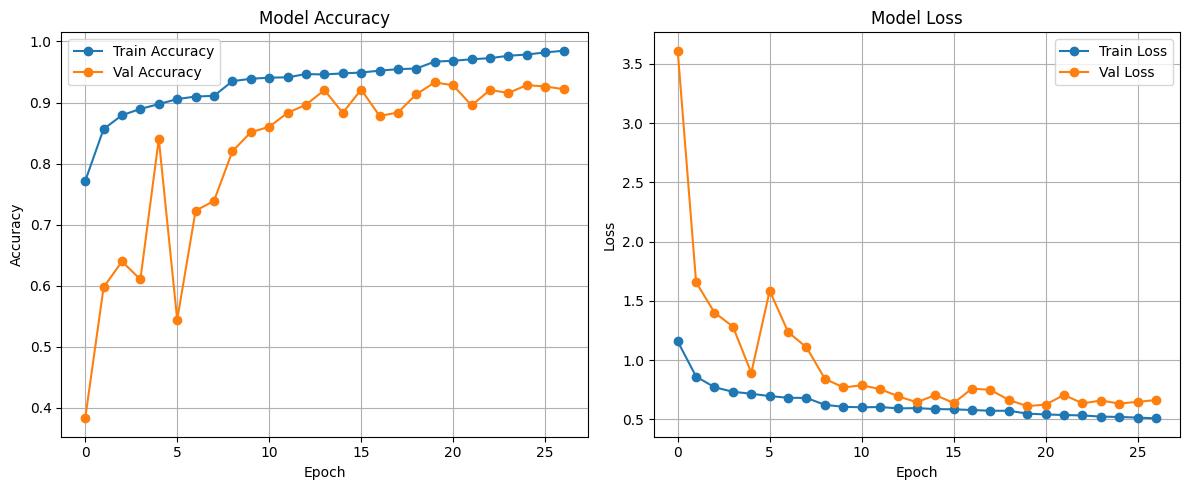

In [20]:
import matplotlib.pyplot as plt

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

# Get true & predicted labels
y_true, y_pred = [], []

for images, labels in val_gen:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_gen.samples:
        break

# Print report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━

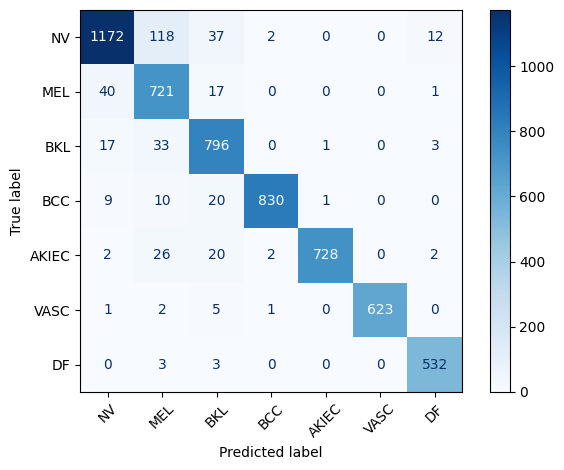

In [22]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.tight_layout()
plt.show()

# Test the Model

In [23]:
# Load best model
from tensorflow.keras.models import load_model
model = load_model("best_model_synthetic_augmented.keras")

In [24]:
import pandas as pd
import os

# Load ground truth
test_df = pd.read_csv("/kaggle/input/synthetic-data-ham10000/ISIC2018_Task3_Test_GroundTruth.csv")

# Drop unlabeled rows (if any)
test_df = test_df.dropna()

# Convert one-hot to class label
test_df['label'] = test_df.drop('image', axis=1).idxmax(axis=1)
test_df['filename'] = test_df['image'].apply(lambda x: x + '.jpg')
test_df = test_df[['filename', 'label']]

In [25]:
# Test data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/synthetic-data-ham10000/test_images/test_images',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1512 validated image filenames belonging to 7 classes.


In [26]:
# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 436ms/step - accuracy: 0.1246 - loss: 3.5577
Test Accuracy: 0.1144


In [27]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step
              precision    recall  f1-score   support

       AKIEC       0.00      0.07      0.01        43
         BCC       0.00      0.00      0.00        93
         BKL       0.49      0.75      0.59       217
          DF       0.02      0.05      0.03        44
         MEL       0.06      0.01      0.02       171
          NV       0.00      0.00      0.00       909
        VASC       0.04      0.11      0.05        35

    accuracy                           0.11      1512
   macro avg       0.09      0.14      0.10      1512
weighted avg       0.08      0.11      0.09      1512



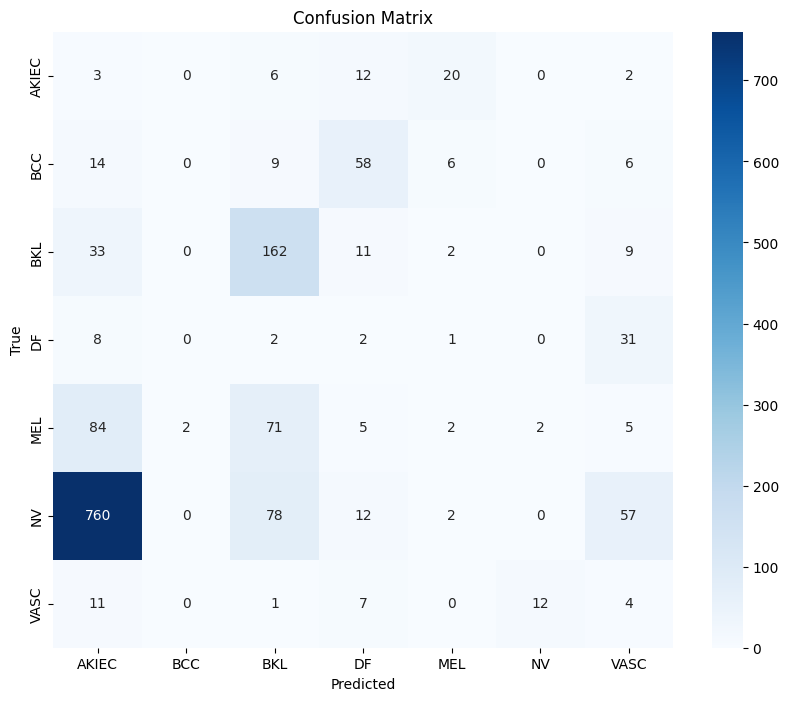

In [28]:
# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()